In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

from utils_ode import *
from odes_hd import *
from utils_verify import max_lyapunov_benettin
from utils_ode import parse_ode_equations, plot_3d_ode, plot_power_spectrum

from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
# new
class VectorFieldModelComponents:
    def __init__(self, grid_limits, grid_shape, basis_funcs):
        """
        grid_limits: 每个维度的取值区间，例如 [[0,1], [0,1], [0,1]]
        grid_shape: 每个维度的点数，例如 (48,48,48)
        basis_funcs: 字典，键为 'x','y','z'（表示向量场各分量），
                     值为对应分量的基函数列表，每个元素为 (f, name) 的元组，
                     其中 f(x,y,z) 为实现，name 为该基函数的字符串描述。
        """
        self.grid_limits = grid_limits
        self.grid_shape = grid_shape
        self.basis_funcs = basis_funcs
        self.coeffs = {}  # 存储各分量的拟合系数，格式为字典，键 'x','y','z'
        self._generate_grid()
        
    def _generate_grid(self):
        # 根据网格参数生成各维度的坐标和三维网格
        self.grids = [np.linspace(lim[0], lim[1], num) 
                      for lim, num in zip(self.grid_limits, self.grid_shape)]
        self.xg, self.yg, self.zg = self.grids
        # 使用 indexing='ij' 保证网格顺序与数据对应
        x, y, z = np.meshgrid(self.xg, self.yg, self.zg, indexing='ij')
        self.x = x
        self.y = y
        self.z = z
        self.N = x.size
        # 将三维坐标展平成一维数组（形状均为 (N,)）
        self.x_flat = x.flatten()
        self.y_flat = y.flatten()
        self.z_flat = z.flatten()
    
    def _build_design_matrix_component(self, comp):
        """
        为向量场分量 comp（'x','y','z'）构建设计矩阵，
        每个基函数 f(x,y,z) 返回形状为 (N,) 的数组
        """
        funcs = self.basis_funcs[comp]
        # 注意：这里每个元素是一个 (f, name) 元组
        X = np.column_stack([f(self.x_flat, self.y_flat, self.z_flat) for f, name in funcs])
        return X
    
    def fit(self, vecs, regression="linear", alpha=1.0):
        """
        vecs: 向量场数据，形状应为 (grid_shape..., 3)
        regression: 使用的回归方法，取值 "linear"、"lasso" 或 "ridge"
        alpha: 正则化参数（仅对 lasso 和 ridge 有效）
        
        分别构建设计矩阵并拟合各分量的系数
        """
        # 构建设计矩阵
        X_x = self._build_design_matrix_component('x')
        X_y = self._build_design_matrix_component('y')
        X_z = self._build_design_matrix_component('z')
        
        # 展平向量场数据各分量
        vecs_x = vecs[:, :, :, 0].flatten()
        vecs_y = vecs[:, :, :, 1].flatten()
        vecs_z = vecs[:, :, :, 2].flatten()
        
        # 根据选择的回归方法拟合
        if regression == "linear":
            model_x = LinearRegression(fit_intercept=False).fit(X_x, vecs_x)
            model_y = LinearRegression(fit_intercept=False).fit(X_y, vecs_y)
            model_z = LinearRegression(fit_intercept=False).fit(X_z, vecs_z)
        elif regression == "lasso":
            model_x = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000).fit(X_x, vecs_x)
            model_y = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000).fit(X_y, vecs_y)
            model_z = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000).fit(X_z, vecs_z)
        elif regression == "ridge":
            model_x = Ridge(alpha=alpha, fit_intercept=False).fit(X_x, vecs_x)
            model_y = Ridge(alpha=alpha, fit_intercept=False).fit(X_y, vecs_y)
            model_z = Ridge(alpha=alpha, fit_intercept=False).fit(X_z, vecs_z)
        else:
            raise ValueError("Unsupported regression method: choose 'linear', 'lasso' or 'ridge'")
        
        self.coeffs['x'] = model_x.coef_
        self.coeffs['y'] = model_y.coef_
        self.coeffs['z'] = model_z.coef_
        
        # 输出 dS/dt, dE/dt, dI/dt 的多项式表达式
        self.print_polynomial('x')
        self.print_polynomial('y')
        self.print_polynomial('z')
        
        # 新增：输出 dR/dt 的表达式
        self.print_polynomial_dR()
    
    def print_polynomial(self, comp):
        """
        根据拟合得到的系数和基函数名称，输出具体的多项式表达式
        comp: 'x', 'y' 或 'z'
        """
        coeffs = self.coeffs[comp]
        funcs = self.basis_funcs[comp]
        terms = []
        for i, (f, name) in enumerate(funcs):
            coef = coeffs[i]
            # 忽略系数非常小的项
            if abs(coef) > 1e-6:
                term = f"{coef:.4f}*{name}"
                terms.append(term)
        expr = " + ".join(terms) if terms else "0"
        if comp == 'x':
            print("dS/dt = " + expr)
        elif comp == 'y':
            print("dE/dt = " + expr)
        elif comp == 'z':
            print("dI/dt = " + expr)
    
    def print_polynomial_dR(self):
        """
        根据拟合得到的 dS/dt, dE/dt 和 dI/dt 多项式，输出 dR/dt 的表达式，
        其中 dR/dt = - (dS/dt + dE/dt + dI/dt)
        假设各分量的基函数顺序相同。
        """
        # 将三个分量的系数逐项相加
        combined_coeffs = self.coeffs['x'] + self.coeffs['y'] + self.coeffs['z']
        funcs = self.basis_funcs['x']  # 假定三个分量的基函数顺序一致
        terms = []
        for i, (f, name) in enumerate(funcs):
            if i == 0:
                # 常数项：- (coeff_x0 + coeff_y0 + coeff_z0)
                const_coef = - combined_coeffs[0]
                if abs(const_coef) > 1e-6:
                    terms.append(f"{const_coef:.4f}")
            else:
                # 其他项：系数为 -(coeff_xi+coeff_yi+coeff_zi)
                coef = -combined_coeffs[i]
                if abs(coef) > 1e-6:
                    terms.append(f"{coef:.4f}*{name}")
        expr = " + ".join(terms) if terms else "0"
        print("dR/dt = " + expr)
    
    def vector_field(self, t, state):
        """
        根据拟合系数计算向量场在点 (x,y,z) 处的值，用于 ODE 数值积分
        state: [x, y, z]
        """
        x_val, y_val, z_val = state
        # 分别计算每个分量的基函数在 (x,y,z) 处的值
        basis_x = np.array([f(x_val, y_val, z_val) for f, name in self.basis_funcs['x']])
        basis_y = np.array([f(x_val, y_val, z_val) for f, name in self.basis_funcs['y']])
        basis_z = np.array([f(x_val, y_val, z_val) for f, name in self.basis_funcs['z']])
        
        fx = np.dot(self.coeffs['x'], basis_x)
        fy = np.dot(self.coeffs['y'], basis_y)
        fz = np.dot(self.coeffs['z'], basis_z)
        return [fx, fy, fz]

    def plot_trajectory(self, y0, t_span, t_eval=None, figsize=(4,3), num_point=200, save_config=False, save_path=None):
        """
        利用拟合的向量场求解 ODE, 并绘制三维轨迹
        y0: 初始条件，例如 [0.5, 0.5, 0.5]
        t_span: 积分时间区间，例如 (0, 10)
        """
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], num_point)
            
        sol = solve_ivp(self.vector_field, t_span, y0, t_eval=t_eval)
        
        fig = plt.figure(figsize=figsize)
        fig.patch.set_alpha(0)
        
        ax = fig.add_subplot(111, projection='3d')
        ax.patch.set_facecolor('none')
        ax.xaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        ax.plot(sol.y[0], sol.y[1], sol.y[2], lw=2, color='black')

        # 每个轴最多 5 个主刻度
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.zaxis.set_major_locator(MaxNLocator(nbins=2))

        # 调整刻度：间距设为 0、字体放大到 14pt
        for axis in ('x', 'y', 'z'):
            ax.tick_params(axis=axis, pad=0, labelsize=16)

        # ax.tick_params(axis='x', pad=0)
        # ax.tick_params(axis='y', pad=0)
        # ax.tick_params(axis='z', pad=0)
        # ax.set_xlabel('S', fontsize=10, labelpad=-2)
        # ax.set_ylabel('E', fontsize=10, labelpad=-2)
        # ax.set_zlabel('I', fontsize=10, labelpad=-2)
        
        if save_config:
            plt.savefig(save_path + 'attractor.png', dpi=450)
        plt.show()
        return sol

    def plot_state_curves(self, y0, t_span, t_eval=None, figsize=(5,5), num_point=1000, \
                          x_label_on=False, y_label_on=False, x_ticks_on=True, y_ticks_on=True, save_config=False, save_path=None):
        """
        利用拟合的向量场求解 ODE, 并在同一张图中绘制 x, y, z 三个状态随时间变化的曲线
        y0: 初始条件，例如 [0.5, 0.5, 0.5]
        t_span: 积分时间区间，例如 (0, 10)
        """
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], num_point)
        sol = solve_ivp(self.vector_field, t_span, y0, t_eval=t_eval)
        
        qianlan = '#73BAD6'
        shenlan = '#02263E'
        qianhong = '#EF4143'
        shenhong = '#BF1E2E'

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(sol.t, sol.y[0], label='S', color=qianhong)
        ax.plot(sol.t, sol.y[1], '--', label='E', color=shenlan)
        ax.plot(sol.t, sol.y[2], label='I', color=qianlan)
        ax.tick_params(direction='in', labelsize=20)
        ax.tick_params(axis='x', labelbottom=x_ticks_on)
        ax.tick_params(axis='y', labelleft=y_ticks_on)
        from matplotlib.ticker import MaxNLocator
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        if x_label_on:
            ax.set_xlabel('Time', fontsize=20)
        if y_label_on:
            ax.set_ylabel('Percentage', fontsize=20)
        plt.legend(prop={'size':15}, loc='upper left')
        if save_config:
            plt.savefig(save_path + 'state.png', dpi=450, bbox_inches='tight', pad_inches=0)
        plt.show()
        return sol


dS/dt = -0.0384*S + -0.0408*E + -0.0397*I + -0.8722*S*I + -0.0021*E^2 + -0.0093*E*I
dE/dt = 0.0089*S + -0.0424*E + 0.7312*S*I
dI/dt = 0.0155*E + -0.1353*I + 0.0123*E^2
dR/dt = 0.0295*S + 0.0677*E + 0.1750*I + 0.1410*S*I + -0.0102*E^2 + 0.0093*E*I


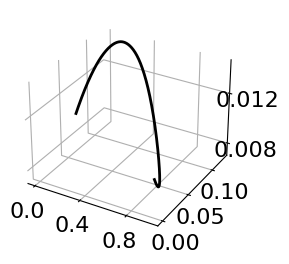

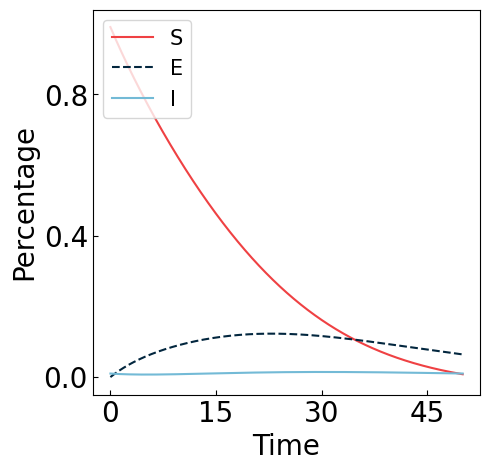

In [3]:
# -------------------------------
# 主程序示例
# -------------------------------
if __name__ == '__main__':
    # 定义向量场各分量的基函数，注意每个元素是 (f, name) 的元组
    vecs = np.load('./results/exp_lls_styleon/vecs_seirs_lorenz_tiny_transfer_exp_lls_styleon.npy')

    basis_funcs_verbose = {
    'x': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ],
    'y': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ],
    'z': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ]
}

    
    grid_limits = [[0, 1], [0, 1], [0, 1]]
    grid_shape = (48, 48, 48)
    
    # 构造模型
    model = VectorFieldModelComponents(grid_limits, grid_shape, basis_funcs_verbose)
    
    system_label=[6,0]
    vec = vecs[system_label[0], system_label[1]]
    save_path = f'./seir_image/system{system_label[0]}_system{system_label[1]}'
    
    # 拟合各向量分量的系数，并选择回归方法
    model.fit(vec, regression="lasso", alpha=0.005)
    #model.fit(vec, regression="linear", alpha=0.005)
    
    # 直接调用 plot_trajectory 方法进行 ODE 数值积分和轨迹可视化
    y0 = [0.99, 0.0, 0.01]  # 初始条件
    t_span = (0, 50)
    model.plot_trajectory(y0, t_span=(0,50), num_point=5000, save_config=True, save_path=save_path)
    
    model.plot_state_curves(y0, t_span, num_point=5000, x_label_on=True, y_label_on=True, x_ticks_on=True, y_ticks_on=True, save_config=True, save_path=save_path)


dS/dt = 0.1881*1 + 0.7907*S*I + -0.0565*E^2 + -0.1112*I^2
dE/dt = -0.0179*1 + 1.7189*S*I + -0.0171*E^2 + 0.0477*I^2
dI/dt = -0.0028*1 + -0.0620*I + 0.1300*S^2 + 0.1294*S*I
dR/dt = -0.1674 + 0.0620*I + -0.1300*S^2 + -2.6390*S*I + 0.0736*E^2 + 0.0635*I^2


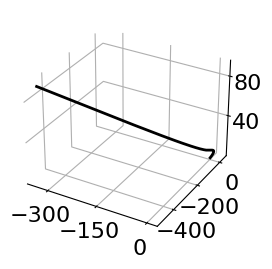

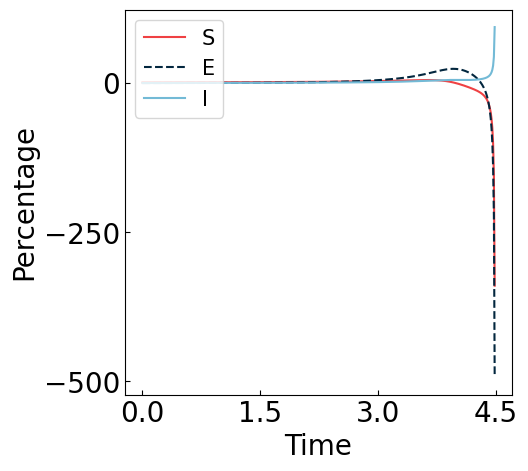

In [4]:
# -------------------------------
# 主程序示例
# -------------------------------
if __name__ == '__main__':
    # 定义向量场各分量的基函数，注意每个元素是 (f, name) 的元组
    vecs = np.load('./results/exp_lls_styleon_critical/vecs_seirs_lorenz_tiny_transfer_exp_lls_styleon_critical.npy')

    basis_funcs_verbose = {
    'x': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ],
    'y': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ],
    'z': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ]
}

    
    grid_limits = [[0, 1], [0, 1], [0, 1]]
    grid_shape = (48, 48, 48)
    
    # 构造模型
    model = VectorFieldModelComponents(grid_limits, grid_shape, basis_funcs_verbose)
    
    system_label=[9,0]
    vec = vecs[system_label[0], system_label[1]]
    save_path = f'./seir_image/system{system_label[0]}_system{system_label[1]}'
    
    # 拟合各向量分量的系数，并选择回归方法
    model.fit(vec, regression="lasso", alpha=0.005)
    #model.fit(vec, regression="linear", alpha=0.005)
    
    # 直接调用 plot_trajectory 方法进行 ODE 数值积分和轨迹可视化
    y0 = [0.99, 0.0, 0.01]  # 初始条件
    t_span = (0, 50)
    model.plot_trajectory(y0, t_span=(0,50), num_point=5000, save_config=True, save_path=save_path)
    
    model.plot_state_curves(y0, t_span, num_point=5000, x_label_on=True, y_label_on=True, x_ticks_on=True, y_ticks_on=True, save_config=True, save_path=save_path)


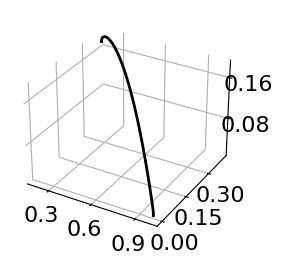

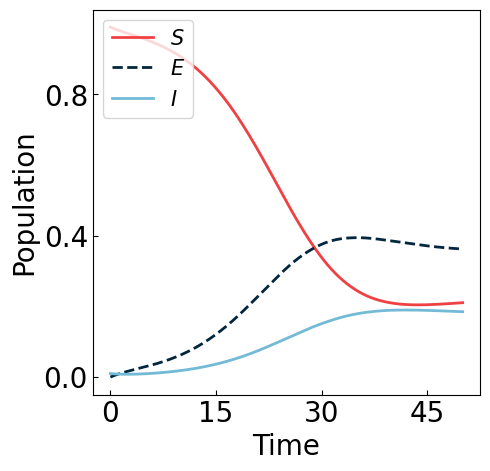

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# -------------------------------
# SEIR 向量场定义（仅积分 S, E, I）
# 总人口 N=1，且 R = 1 - (S+E+I)
def seir_vector_field(t, state):
    S, E, I = state
    R = 1 - (S + E + I)
    beta = 0.9    # 感染率
    sigma = 0.1   # 潜伏期倒数
    gamma = 0.2   # 康复率
    xi = 0.15     # 失去免疫率
    dSdt = - beta * S * I + xi * R
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    return [dSdt, dEdt, dIdt]

# 初始条件：S=0.99, E=0, I=0.01
y0 = [0.99, 0, 0.01]
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 5000)

# 数值积分
sol = solve_ivp(seir_vector_field, t_span, y0, t_eval=t_eval)

# -------------------------------
# 定义配色
qianlan = '#73BAD6'
shenlan = '#02263E'
qianhong = '#EF4143'
shenhong = '#BF1E2E'

# 1. 绘制三维轨迹图（仅绘制 SEI 空间轨迹）
fig = plt.figure(figsize=(4,3))
fig.patch.set_alpha(0)
ax3d = fig.add_subplot(111, projection='3d')
ax3d.patch.set_facecolor('none')
ax3d.xaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
ax3d.yaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
ax3d.zaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
ax3d.xaxis.pane.set_edgecolor('none')
ax3d.yaxis.pane.set_edgecolor('none')
ax3d.zaxis.pane.set_edgecolor('none')
ax3d.plot(sol.y[0], sol.y[1], sol.y[2], lw=2, color='black')

# 每个轴最多 5 个主刻度
ax3d.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax3d.yaxis.set_major_locator(MaxNLocator(nbins=3))
ax3d.zaxis.set_major_locator(MaxNLocator(nbins=2))

# 调整刻度：间距设为 0、字体放大到 14pt
for axis in ('x', 'y', 'z'):
    ax3d.tick_params(axis=axis, pad=0, labelsize=16)

# ax3d.tick_params(axis='x', pad=0)
# ax3d.tick_params(axis='y', pad=0)
# ax3d.tick_params(axis='z', pad=0)
# ax3d.set_xlabel('S', fontsize=10, labelpad=-2)
# ax3d.set_ylabel('E', fontsize=10, labelpad=-2)
# ax3d.set_zlabel('I', fontsize=10, labelpad=-2)
plt.title("")  # 不显示标题
plt.savefig('./seir_image/classial_attractor.png', dpi=450)
plt.show()

# -------------------------------
# 2. 绘制状态曲线图（S, E, I 随时间变化）
plt.figure(figsize=(5,5))
plt.plot(sol.t, sol.y[0], label=r'$S$', color=qianhong, lw=2)
plt.plot(sol.t, sol.y[1], '--', label=r'$E$', color=shenlan, lw=2)
plt.plot(sol.t, sol.y[2], label=r'$I$', color=qianlan, lw=2)
plt.xlabel(r'Time', fontsize=20)
plt.ylabel(r'Population', fontsize=20)
plt.legend(prop={'size':15}, loc='upper left')
#plt.tight_layout()

ax = plt.gca()

# 指定 x 轴“最多”4个主刻度，y 轴“最多”3个主刻度
ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune=None))
ax.yaxis.set_major_locator(MaxNLocator(nbins=3, prune=None))
ax.tick_params(labelsize=20, direction='in')

plt.savefig('./seir_image/classial_state.png', dpi=450)
plt.show()


dS/dt = -0.0385*S + -0.0412*E + -0.0397*I + -0.8719*S*I + -0.0016*E^2 + -0.0093*E*I
dE/dt = 0.0087*S + -0.0424*E + 0.7314*S*I
dI/dt = 0.0149*E + -0.1352*I + 0.0130*E^2
dR/dt = 0.0298*S + 0.0687*E + 0.1750*I + 0.1405*S*I + -0.0114*E^2 + 0.0093*E*I
dS/dt = -0.0385*S + -0.0412*E + -0.0397*I + -0.8719*S*I + -0.0016*E^2 + -0.0093*E*I
dE/dt = 0.0087*S + -0.0424*E + 0.7314*S*I
dI/dt = 0.0149*E + -0.1352*I + 0.0130*E^2
dR/dt = 0.0298*S + 0.0688*E + 0.1750*I + 0.1405*S*I + -0.0114*E^2 + 0.0093*E*I
dS/dt = -0.0385*S + -0.0412*E + -0.0398*I + -0.8719*S*I + -0.0016*E^2 + -0.0093*E*I
dE/dt = 0.0087*S + -0.0424*E + 0.7314*S*I
dI/dt = 0.0149*E + -0.1352*I + 0.0130*E^2
dR/dt = 0.0298*S + 0.0688*E + 0.1750*I + 0.1405*S*I + -0.0114*E^2 + 0.0093*E*I
dS/dt = -0.0385*S + -0.0412*E + -0.0397*I + -0.8719*S*I + -0.0016*E^2 + -0.0093*E*I
dE/dt = 0.0087*S + -0.0424*E + 0.7314*S*I
dI/dt = 0.0149*E + -0.1352*I + 0.0130*E^2
dR/dt = 0.0298*S + 0.0688*E + 0.1749*I + 0.1405*S*I + -0.0114*E^2 + 0.0093*E*I
dS/dt = -0.0

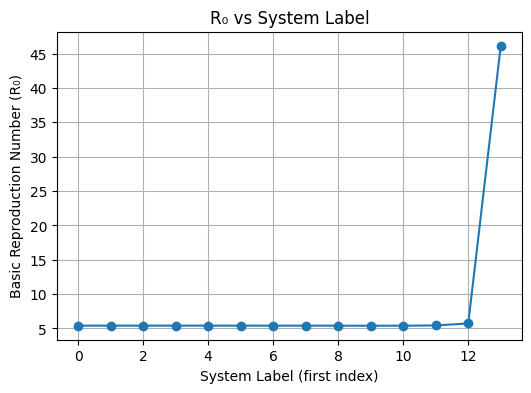

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# 假设你已定义 VectorFieldModelComponents 类以及 basis_funcs_verbose, grid_limits, grid_shape 等

# 载入向量场数据
vecs = np.load('./results/exp_lls_styleon/vecs_seirs_lorenz_tiny_transfer_exp_lls_styleon.npy')
#vecs = np.load('./results/exp_lls_styleon_critical/vecs_seirs_lorenz_tiny_transfer_exp_lls_styleon_critical.npy')

# 用于存储各系统的 R0 和 ODE 输出
R0_values = []
ode_solutions = []

grid_limits = [[0, 1], [0, 1], [0, 1]]
grid_shape = (48, 48, 48)


basis_funcs_verbose = {
    'x': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ],
    'y': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ],
    'z': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "S"),
        (lambda x, y, z: y, "E"),
        (lambda x, y, z: z, "I"),
        (lambda x, y, z: x**2, "S^2"),
        (lambda x, y, z: x*y, "S*E"),
        (lambda x, y, z: x*z, "S*I"),
        (lambda x, y, z: y**2, "E^2"),
        (lambda x, y, z: y*z, "E*I"),
        (lambda x, y, z: z**2, "I^2"),
    ]
}


# 遍历 system_label[0] 从 0 到 12，system_label[1] 固定为 0
num_system = 14
for i in range(num_system):
    system_label = [i, 0]
    vec = vecs[system_label[0], system_label[1]]
    
    # 构造模型
    model = VectorFieldModelComponents(grid_limits, grid_shape, basis_funcs_verbose)
    
    # 拟合向量场（这里采用 Lasso 回归）
    model.fit(vec, regression="lasso", alpha=0.005)
    
    # 提取 dE/dt 中 "S*I" 项的系数：
    # basis_funcs_verbose['y'] 列表中 "S*I" 对应下标为 6
    coeff_SI = model.coeffs['y'][6]
    
    # 提取 dI/dt 中 "I" 项的系数：
    # basis_funcs_verbose['z'] 列表中 "I" 对应下标为 3
    coeff_I = model.coeffs['z'][3]
    
    # 计算基本再生数 R0
    R0 = coeff_SI / (-coeff_I)
    R0_values.append(R0)
    
    # 记录 ODE 输出
    y0 = [0.99, 0.0, 0.01]
    t_span = (0, 80)
    t_eval = np.linspace(t_span[0], t_span[1], 8000)
    sol = solve_ivp(model.vector_field, t_span, y0, t_eval=t_eval)
    ode_solutions.append(sol)
    
    #print(f"System {i}: R0 = {R0:.4f}")

# 绘制 R0 随系统编号变化的折线图
plt.figure(figsize=(6, 4))
plt.plot(range(num_system), R0_values, marker='o', linestyle='-')
plt.xlabel("System Label (first index)")
plt.ylabel("Basic Reproduction Number (R₀)")
plt.title("R₀ vs System Label")
plt.grid(True)
plt.show()


In [34]:
cu = R0_values
print(len(cu))

14


In [31]:
xi = R0_values
len(xi)

10

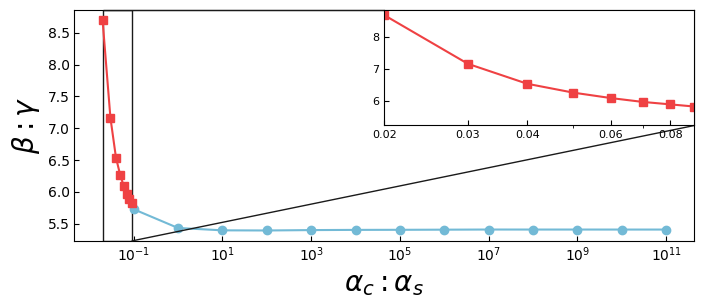

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import FormatStrFormatter

        
qianlan = '#73BAD6'
shenlan = '#02263E'
qianhong = '#EF4143'
shenhong = '#BF1E2E'

# Custom scientific formatter to display numbers like 2e-4
def sci_formatter(x, pos):
    s = f"{x:.0e}"
    s = s.replace("e-0", "e-").replace("e+0", "e+")
    return s

# Corresponding indices
cu_idx = [1e11, 1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1e1, 1.0, 0.1, 0.01]
xi_idx = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]

# Assume cu and xi are your data lists.
# Use the first 13 points for cu and points 2-9 for xi to avoid duplicate at 0.001.
cu_plot = cu[:13]
xi_plot = xi[1:9]
cu_idx_plot = cu_idx[:13]
xi_idx_plot = xi_idx[1:9]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(cu_idx_plot, cu_plot, label='cu', marker='o', color=qianlan)
ax.plot(xi_idx_plot, xi_plot, label='xi', marker='s', color=qianhong)
ax.set_xlabel(r"$\alpha_c : \alpha_s$", fontsize=20)
#ax.set_ylabel(r"$R_0$", fontsize=20)
ax.set_ylabel(r"$\beta : \gamma$", fontsize=20)
ax.set_xscale("log")
ax.legend()

# Set tick marks to point inward for the main axes
ax.tick_params(direction='in')

# Create an inset for the zoomed-in region [2e-4, 9e-4]
# Use borderpad=0 to have the inset flush with the top-right corner.
ax_inset = inset_axes(ax, width="50%", height="50%", loc='upper right', borderpad=0)
ax_inset.plot(cu_idx_plot, cu_plot, marker='o', color=qianlan)
ax_inset.plot(xi_idx_plot, xi_plot, marker='s', color=qianhong)
ax_inset.set_xscale("log")
ax_inset.set_xlim(2e-2, 9e-2)
# Set custom x-ticks for the inset
custom_ticks = [0.02, 0.03, 0.04, 0.06, 0.08]
ax_inset.set_xticks(custom_ticks)
ax_inset.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Set tick marks to point inward for the inset
ax_inset.tick_params(axis='x', labelsize=8, direction='in')
ax_inset.tick_params(axis='y', labelsize=8, direction='in')

# Connect the main axes and inset
mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.1")
plt.savefig('./r0.png', dpi=450, bbox_inches='tight')
plt.show()
